# Homework 3 

You will have 2 datasets to work on. 
#### You have to answer questions in this [form](https://goo.gl/forms/5gfxvKZxpoydoeOB2) and provide your code

### 1. Wikipedia Web Traffic Time Series

Data from [Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting)* )

*wikipedia_train3* - train data *wikipedia_test3* - test data created by us from original train data . For more information about dataset, please visit Homework1 assignment

## Wikipedia page views (SMAPE metric)

In [41]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
### This is data from wikipedia3 archive in data folder
train = pd.read_csv("../data/wikipedia_train3.csv", parse_dates=['date'])
test = pd.read_csv("../data/wikipedia_test3.csv")

### Preprocess

In [43]:
N_samples = train.Page.nunique()
test.Page.nunique()

11815

In [44]:
train.head(1)

,Page,date,Visits
0,Special:Search_zh.wikipedia.org_all-access_spider,2016-01-01,2660.0


In [45]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res.group(0)[0:2]
    return 'na'

In [46]:
def get_dop_features(df):
    dop_features = set()
    for page in df.Page:
        dop_features.update(get_attributes(page))
    dop_features.remove('spider')
    return list(dop_features)

In [47]:
def get_attributes(page):
    return re.search('(?<=\.org_).*', page).group().split('_')

In [48]:
def new_df(df):
    df_new = df.pivot(index='Page', columns='date', values='Visits')
    df_pages = pd.DataFrame(df_new.index, columns=['Page'])
    df_values = pd.DataFrame(df_new.values, columns=df_new.columns)
    res = pd.concat([df_pages, df_values], axis=1)
    dop_features = get_dop_features(df)
    for i in dop_features:
        res[i] = res.Page.apply(lambda x: int(i in get_attributes(x)))
    return res

In [49]:
new_train = new_df(train)
new_test = new_df(test)

In [50]:
new_test.head(1)

,Page,2016-09-10,2016-09-11,2016-09-12,2016-09-13,2016-09-14,2016-09-15,2016-09-16,2016-09-17,2016-09-18,...,2016-11-05,2016-11-06,2016-11-07,2016-11-08,2016-11-09,2016-11-10,all-access,desktop,all-agents,mobile-web
0,"""Weird_Al""_Yankovic_en.wikipedia.org_all-acces...",3750.0,3301.0,3450.0,3132.0,3460.0,3369.0,2936.0,3245.0,3327.0,...,3682.0,7560.0,3592.0,3235.0,2331.0,4515.0,1,0,1,0


In [51]:
def get_subdataframe(dataframe, attrib={}):
    df = dataframe
    for key, value in attrib.items():
        df = df[df[key]==value]
    return df

In [52]:
def count_plots(df):
    sns.set_style('ticks')
    _, axes = plt.subplots(1, 4, figsize=(16, 4))
    for ax, name in zip(axes.flatten(), new_train.columns[-4:]):        
        sns.countplot(x=name, data=df, ax=ax)
        ax.tick_params(labelsize=6)
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_title(name, fontsize=10)

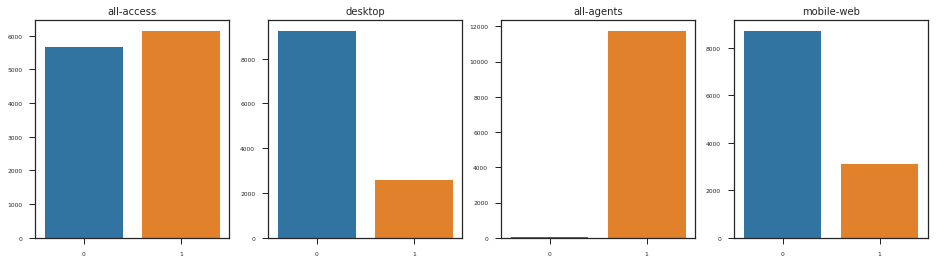

In [53]:
count_plots(get_subdataframe(new_train))

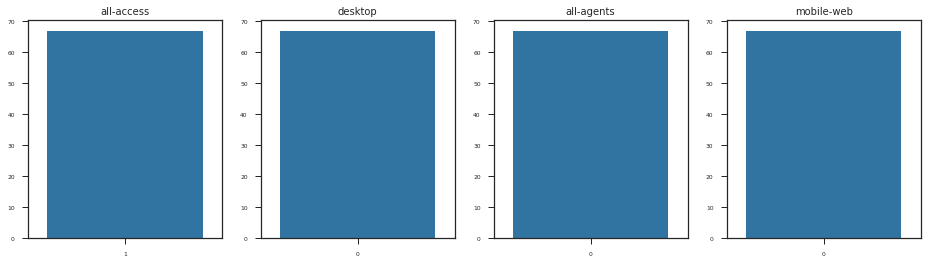

In [54]:
count_plots(get_subdataframe(new_train, attrib={'all-agents': 0}))

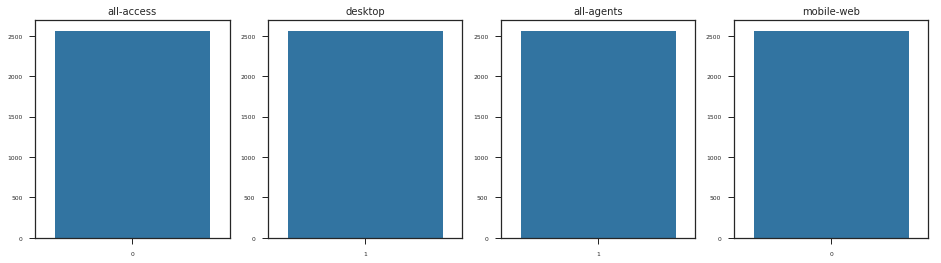

In [55]:
count_plots(get_subdataframe(new_train, attrib={'all-agents': 1, 'desktop': 1}))

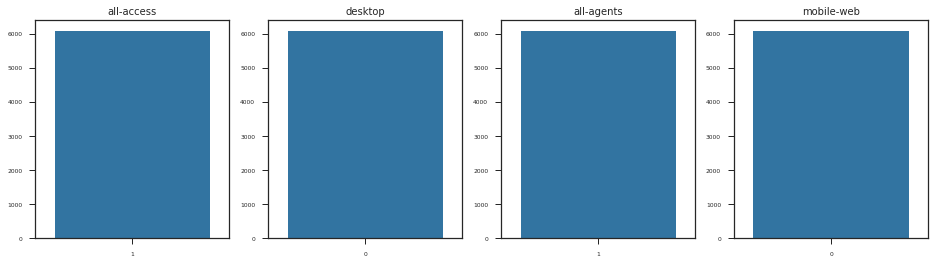

In [56]:
count_plots(get_subdataframe(new_train, attrib={'all-agents': 1, 'desktop': 0, 'all-access':1}))

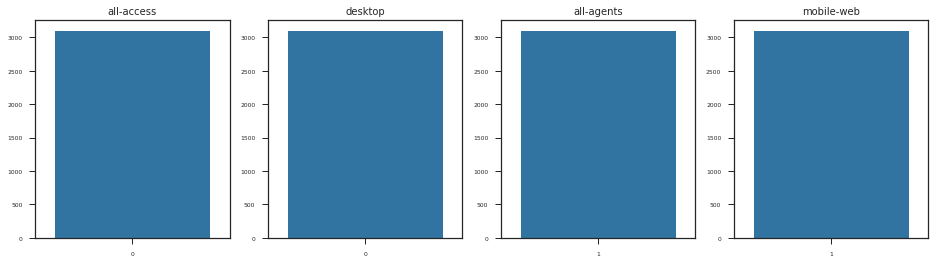

In [57]:
count_plots(get_subdataframe(new_train, attrib={'all-agents': 1, 'desktop': 0, 'all-access':0}))

In [58]:
Groups = {
    1: {'all-agents': 0},
    2: {'all-agents': 1, 'desktop': 1},   
    3: {'all-agents': 1, 'desktop': 0, 'all-access':0},
    4: {'all-agents': 1, 'desktop': 0, 'all-access':1}
}

In [59]:
def group_selection(sample):
    if sample['all-agents'] == 0:
        return 1
    elif sample['desktop'] == 1:
        return 2
    elif sample['all-access'] == 0:
        return 3
    return 4

In [60]:
def dataframe_to_group(df):
    res = df.copy()
    res['Group'] = res.iloc[:,-4:].apply(
        lambda x: group_selection(x), 
        axis=1)
    res.drop(get_dop_features(df), axis=1, inplace=True)
    return res

In [61]:
train_groups = dataframe_to_group(new_train)
test_groups = dataframe_to_group(new_test)

`train_group1 = train_groups[train_groups['Group'] == 1]
 train_group2 = train_groups[train_groups['Group'] == 2]
 train_group3 = train_groups[train_groups['Group'] == 3]
 train_group4 = train_groups[train_groups['Group'] == 4]`

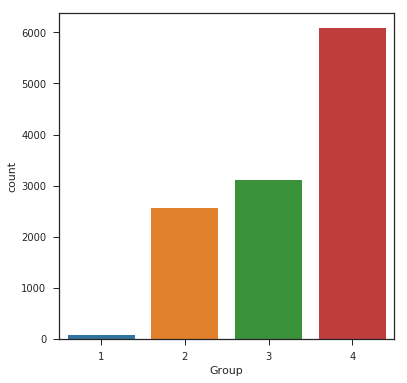

In [62]:
plt.rcParams['figure.figsize'] = (6, 6)
sns.countplot(x='Group', data=train_groups)

#### Datasets reports

In [63]:
# train
pp.ProfileReport(train)

Number of variables,3
Number of observations,2882860
Total Missing (%),0.0%
Total size in memory,66.0 MiB
Average record size in memory,24.0 B
Numeric,1
Categorical,1
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [64]:
# test
pp.ProfileReport(test)

Number of variables,3
Number of observations,732530
Total Missing (%),0.0%
Total size in memory,16.8 MiB
Average record size in memory,24.0 B
Numeric,1
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. **For _only_ train** create a holdout validation using any type of split you think is useful here. What is the split type you are using? Answer in google forms

**2.** Write a code to compare the score of your validation and test set. For scoring, use metric SMAPE (code is in lecture). For prediction use 15 previous days median. In the google form write your validation score.

In [65]:
def pandas_smape(dframe):
    df = dframe.copy().fillna(0)
    df["SMAPE"] = 200 * np.abs(df["Visits"] - df["pred_Visits"]) / (df["Visits"] + df["pred_Visits"])
    return df["SMAPE"].fillna(0).mean()

In [66]:
def holdout_val(train_df, test_df, days_train, days_test):
    train_holdout = train_df.iloc[:, :1 + days_train]
    test_holdout = test_df.iloc[:, -(1 + days_test):-1]
    test_holdout['pred_Visits'] = train_holdout.iloc[:, -15:].median(axis=1)
    prediction = pd.melt(test_holdout, id_vars = ['pred_Visits'], value_vars=test_holdout.columns[:-1], var_name='date', value_name='Visits')
    return pandas_smape(prediction)

In [67]:
holdoutSMAPE = holdout_val(train_groups, train_groups, days_train=181, days_test=63)
testSMAPE = holdout_val(train_groups, test_groups, days_train=244, days_test=62)
print('SMAPE holdout: {} \nSMAPE on test: {}\nDIFF: {}'.format(holdoutSMAPE, testSMAPE, holdoutSMAPE - testSMAPE))

SMAPE holdout: 41.351660748429666 
SMAPE on test: 40.00701270204428
DIFF: 1.3446480463853874


**3.** Perform K-fold validation using your type of split. Run GridSearch with any classificator you like and set of parameters to optimize, providing it with your custom validation.  Compare the score of your validation and test set. For scoring, again, use metrics SMAPE. In the google form write your scores on validation and test sets

In [68]:
def median_of_medians(train, test):
    medians = []
    for size in [i for i in length if i <= train.shape[1]]:
        medians.append(train.iloc[:, -size:].median(axis=1))
    test['pred_Visits'] = np.median(medians, axis=0)
    prediction = pd.melt(test, id_vars = ['Page', 'pred_Visits'], value_vars=test.columns[:-2], var_name='date', value_name='Visits')
    return prediction

In [69]:
### Your code here
train_len = 91
test_len = 70
kfold_trains = []
kfold_tests = []
for i in range((244 - train_len) // test_len):
    kfold_trains.append(train_groups.iloc[:, -(1 + train_len + test_len * (i + 1)): -(1 + test_len * (i + 1))])
    _test = train_groups.iloc[:, - (1 + test_len * (i + 1)): -(1 + test_len * i)]
    _test['Page'] = train_groups['Page']
    kfold_tests.append(_test)
length = [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, train_len]
cross_val = []
for train, test in zip(kfold_trains, kfold_tests):
    cross_val.append(pandas_smape(median_of_medians(train, test)))
kfoldSMAPE = np.mean(cross_val)

In [70]:
train_ = train_groups.iloc[:, -1 -train_len:-1]
test_ = test_groups.iloc[:, 1:-1]
test_['Page'] = test_groups.Page
testSMAPE = pandas_smape(median_of_medians(train_, test_))
print('SMAPE kfold: {} \nSMAPE on test: {}\nDIFF: {}'.format(kfoldSMAPE, testSMAPE, kfoldSMAPE - testSMAPE))

SMAPE kfold: 40.35221130420699 
SMAPE on test: 38.459313306277906
DIFF: 1.892897997929083


## French house insurance prediction (MAPE metric)
### 2. French dataset

Target variable is prime_tot_ttc – house of insurance price.<p>
The variables in the files are:<p>
code_postal: postal code of the insured property<p>
nb_pieces: number of rooms<p>
veranda: presence of a veranda<p>
biens_nomades: ceiling of coverage of goods (laptop, tablets, musical instruments ,…)<p>
sit_fam: family situation of the insured<p>
profession: profession of the insured<p>
nature_lri: nature of the insured property<p>
societe: company covering the risk<p>
cdomact: area of activity of the insured<p>
niv_urbanisation: level of urbanization in which is the insured property<p>
age_societaire: age of the member<p>
objets_precieux: presence of precious objects in the insured property<p>
pres_contrat_auto: holding a contract of auto insurance<p>
formule: guarantee formula<p>
sit_juridique: legal situation<p>
surf_habitat: area of insured property<p>
patrimoine_mob: amount of heritage insured furniture<p>
var1 - ... - var11: non-explicit variables<p>

**1.** Take a look carefuly at train and test dataset. Note for you what is the difference in them and how they are dependent. You may use any tool you like, any EDA you want. Decribe your validation and reason for your choice in google form.

**2.** 
+ Implement your validation. 
+ Generate additional features. 
+ Build a model you like/you can. 
+ Wait for training your model. If it takes too much time, listen to https://www.youtube.com/watch?v=XWkGL4eZR3E
+ Submit your scores on validation and test to google form. Use MAPE metric for scoring. 
+ Ланфрен ланфра лантатита

In [71]:
train = pd.read_csv('../data/train_french.csv')
test = pd.read_csv('../data/test_french.csv')

In [72]:
pp.ProfileReport(train)

Number of variables,29
Number of observations,200000
Total Missing (%),0.0%
Total size in memory,44.3 MiB
Average record size in memory,232.0 B
Numeric,15
Categorical,6
Boolean,8
Date,0
Text (Unique),0
Rejected,0


In [73]:
pp.ProfileReport(test)

Number of variables,29
Number of observations,75968
Total Missing (%),0.0%
Total size in memory,16.8 MiB
Average record size in memory,232.0 B
Numeric,15
Categorical,6
Boolean,8
Date,0
Text (Unique),0
Rejected,0


In [74]:
train.nb_pieces.value_counts(normalize=True)

4    0.242100
3    0.239345
1    0.195760
2    0.194170
5    0.128625
Name: nb_pieces, dtype: float64

In [75]:
test.nb_pieces.value_counts(normalize=True)

4    0.207061
3    0.205192
2    0.171993
1    0.171533
6    0.131634
5    0.112587
Name: nb_pieces, dtype: float64

In [76]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['profession', 'sit_fam', 'nature_lri' ]
non_oui_features = ['veranda' , 'var9']

def preprocess(train_, test_):
    train = train_.copy()
    test = test_.copy()
    enc = LabelEncoder()
    all_data = pd.concat([train, test], axis=0)
    for feature in categorical_features:
        enc.fit(all_data[feature])
        train[feature] = enc.transform(train[feature])
        test[feature] = enc.transform(test[feature])
    for feature in non_oui_features:
        train[feature] = train[feature].map({'NON':0, 'OUI':1})
        test[feature] = test[feature].map({'NON':0, 'OUI':1})
    train['niv_urbanisation'] = train['niv_urbanisation'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6, 'G':7, '~':0})
    test['niv_urbanisation'] = test['niv_urbanisation'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5,'F':6, 'G':7, '~':0})
    xtrain = train.drop(['prime_tot_ttc', 'var4'], axis=1) ##var4 ~ var5
    xtest = test.drop(['prime_tot_ttc', 'var4'], axis=1)
    ytrain = train.drop(train.columns[:-1], axis=1)
    ytest = test.drop(train.columns[:-1], axis=1)
    return xtrain, xtest, ytrain, ytest

In [77]:
train__X, test__X, train__Y, test__Y = preprocess(train, test)

In [78]:
def mape(y_true, y_pred):
    """MAPE metrics"""
    return np.sum(100. / y_true.shape[0] * np.abs((y_true - y_pred) / y_true))

def mape_CV(estimator, x_test, y_true):
    y_pred = estimator.predict(x_test)
    return mape(y_true, y_pred)

In [82]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer
from os import cpu_count
from sklearn.model_selection import GridSearchCV

#train__X = train__[train__.nb_pieces !=5].drop('prime_tot_ttc', axis=1)
kf = KFold(n_splits=4, random_state=11, shuffle=False)
params = {'max_depth' : [10],
         "n_estimators": [100]}
grid = GridSearchCV(estimator=XGBRegressor(random_state=11, learning_rate=0.6), param_grid=params, cv=kf, verbose=1,
                    scoring=make_scorer(mape, greater_is_better=False), n_jobs=cpu_count() - 1)
grid.fit(train__X, train__Y['prime_tot_ttc'])

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed:  1.2min finished


GridSearchCV(cv=KFold(n_splits=4, random_state=11, shuffle=False),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.6, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=11,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_depth': [10], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mape, greater_is_better=False), verbose=1)

In [83]:
best_xgb = grid.best_estimator_
test_mape = mape(test__Y['prime_tot_ttc'], best_xgb.predict(test__X))
cv_mape = cross_val_score(estimator=best_xgb, cv=kf, X=train__X,
                         scoring=mape_CV, y=train__Y['prime_tot_ttc']).mean()

In [84]:
print('MAPE kfold: {} \nMAPE on test: {}\nDIFF: {}'.format(cv_mape, test_mape, abs(cv_mape - test_mape)))

MAPE kfold: 8.364447882728955 
MAPE on test: 8.174272388809415
DIFF: 0.19017549391953992
